# Consumption

In [34]:
%%capture
# Import packages
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
# Data gathered from the yearly workbooks https://github.com/acep-uaf/ak-energy-statistics-2011_2021/tree/main/workbooks
# These data reflect manual additions. Note data from 2011-2013 is in final form, where 2014 onward is considered "early release, subject to change"
# There are some errors that I fixed manually and that version of the data is found at `./data/yearly-workbooks/customer-sales-2011-2021.xlsx`

# Import required data
a = pd.read_csv(os.path.join(os.curdir,'data','annual-consumption-by-community-2011-2021.csv')) # sales and customer data
cw = pd.read_csv(os.path.join(os.curdir,'data','region-crosswalk.csv')) # aea to acep region crosswalk

# Assigning ACEP energy regions
a['ACEP Energy Region'] = a['AEA Energy Region'].map(pd.Series(cw['acep_energy_region'].values,index=cw['aea_energy_region']).to_dict())

# Forcing numeric on sales numbers (MWh)
a['Residential Customers'] = pd.to_numeric(a['Residential Customers'], errors='coerce') # force non-compliers to NaN,
a['Commercial Customers'] = pd.to_numeric(a['Commercial Customers'], errors='coerce')
a['Other Customers'] = pd.to_numeric(a['Other Customers'], errors='coerce')
a['Total Customers'] = pd.to_numeric(a['Total Customers'], errors='coerce')
customer_list = ['Residential Customers','Commercial Customers','Other Customers','Total Customers']

a['Residential Sales'] = pd.to_numeric(a['Residential Sales\n MWh'], errors='coerce') # notice differnce in line skip placement
a['Commercial Sales'] = pd.to_numeric(a['Commercial Sales \nMWh'], errors='coerce')
a['Other Sales'] = pd.to_numeric(a['Other Sales \nMWh'], errors='coerce')
a['Total Sales'] = pd.to_numeric(a['Total Sales \nMWh'], errors='coerce')
sales_list = ['Residential Sales','Commercial Sales','Other Sales','Total Sales']

# Converting the sales data from mwh to gwh
for i in sales_list:
    a[i] = a[i] / 1000

# Import the color schemes
schemes = json.load(open(os.path.join(os.curdir, 'color-schemes.json'))) # import the color schemes

## General Overview

## Sales

In [61]:
# Creating a chart showing the overall trends in consumption (start and end comparison)

## Collapsing across the entire state
b = pd.pivot_table(a, index='Year', values=sales_list[:-1], aggfunc='sum').reset_index()
b.rename(columns={'Commercial Sales':'Commercial','Residential Sales':'Residential','Other Sales':'Other'}, inplace=True)
# Looking at the average yearly growth rate
b = b[b.Year.isin([2011,2019])].set_index('Year').T # keeping only 2011 and 2021
plot_order = ['Residential','Commercial','Other']
b = b.reindex(reversed(plot_order))
b['Percent Change'] = ((b[2019] - b[2011])/(b[2011]))*100 # percent change between 2021 and 2011

## central caption to avoid mistyping
caption = 'Note: For EIA reported data, the Other group includes industrial and transportation customers. For PCE reported data, it includes community and government customers. No industrial customers were reported in the PCE data.'

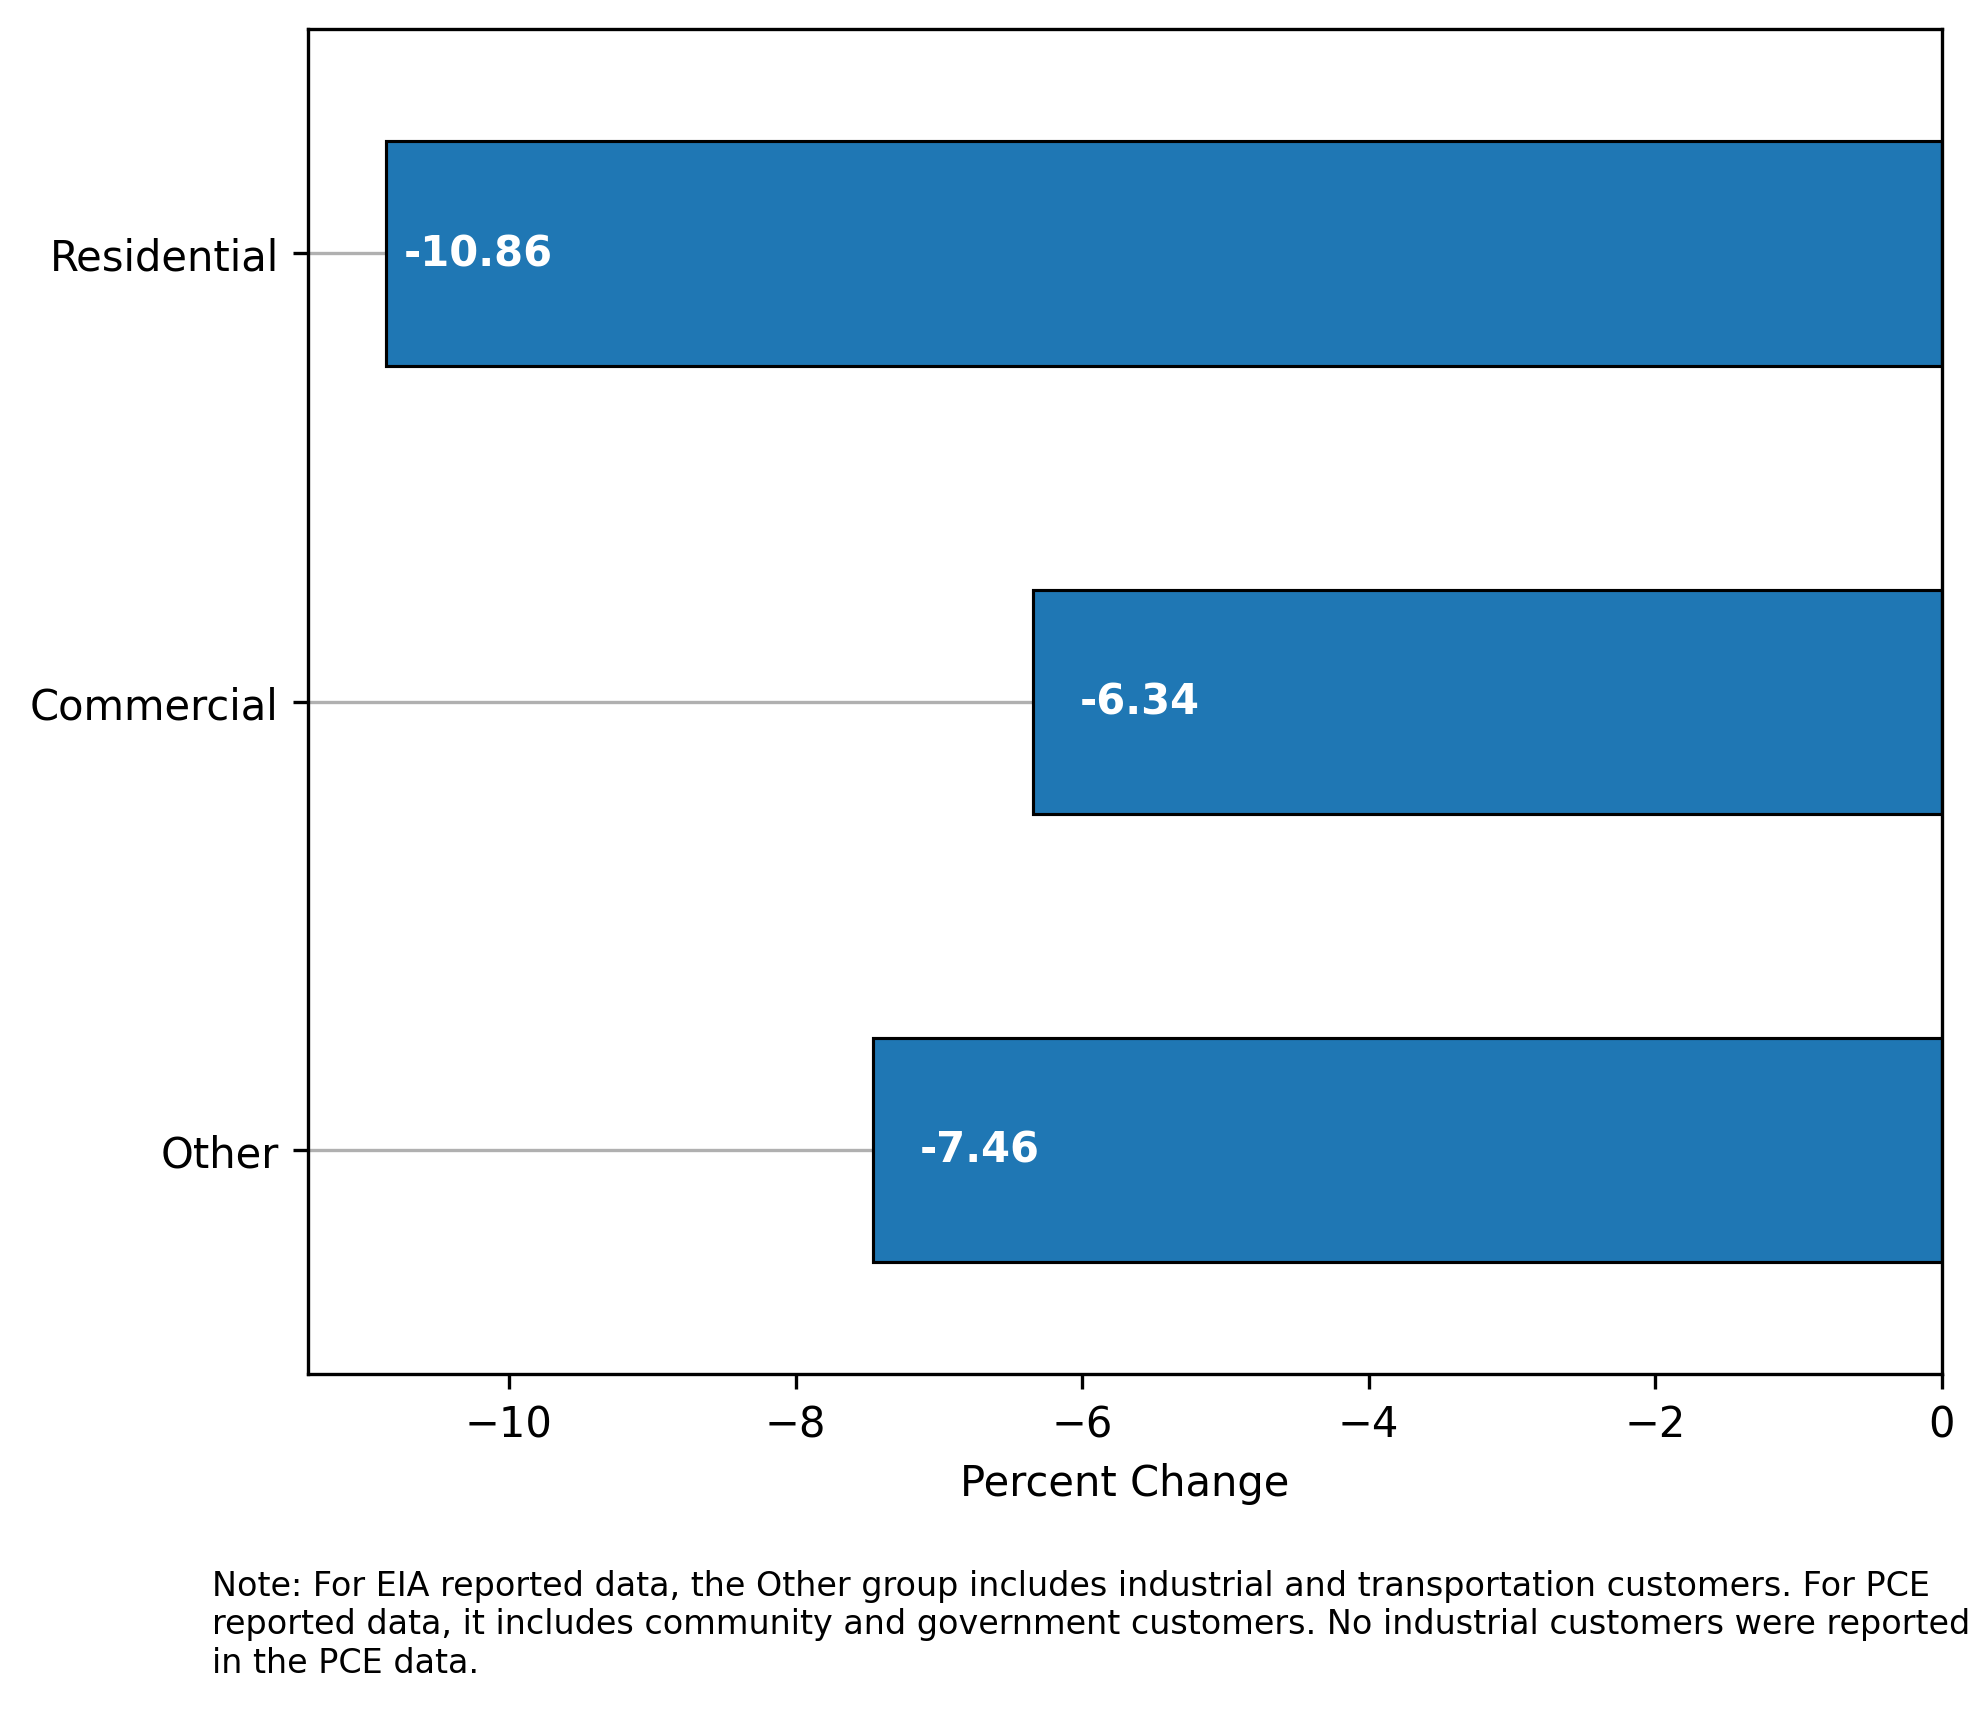

In [62]:
# Plotting and saving the percent change in total sales (GWh) across state and customer classes
fig, ax = plt.subplots(figsize=(6.5,5), layout='constrained')
fig.set_dpi(300)
b.plot(kind='barh',y="Percent Change", edgecolor='black',linewidth=0.75, rot=0, ax=ax, legend=None)
ax.set_ylabel('')
ax.set_xlabel('Percent Change')
ax.grid(axis ='y')
ax.set_axisbelow(True)
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}', fontweight='bold',color='white', label_type='edge', padding=-40)
plt.figtext(0.1,-0.1,caption,wrap=True,ha='left',fontsize=8)
filename = 'statewide-sales-delta'
plt.savefig(os.path.join(os.curdir,'figures',filename + '.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(os.curdir,'figures',filename + '.png'), bbox_inches='tight')

In [63]:
# Change in sales (GWh)
print(round(b,2))

Year            2011     2019  Percent Change
Other        1378.05  1275.27           -7.46
Commercial   2758.38  2583.39           -6.34
Residential  2141.43  1908.86          -10.86


## Customer Accounts

In [64]:
# Creating a chart showing the overall trends in customer accounts (start and end comparison)

## Collapsing across the entire state
c = pd.pivot_table(a, index='Year', values=customer_list[:-1], aggfunc='sum').reset_index()
c.rename(columns={'Commercial Customers':'Commercial','Residential Customers':'Residential','Other Customers':'Other'}, inplace=True)
# Looking at the average yearly growth rate
c = c[c.Year.isin([2011,2019])].set_index('Year').T # keeping only 2011 and 2021
plot_order = ['Residential','Commercial','Other']
c = c.reindex(reversed(plot_order))
c['Percent Change'] = ((c[2019] - c[2011])/(c[2011]))*100 # percent change between 2021 and 2011

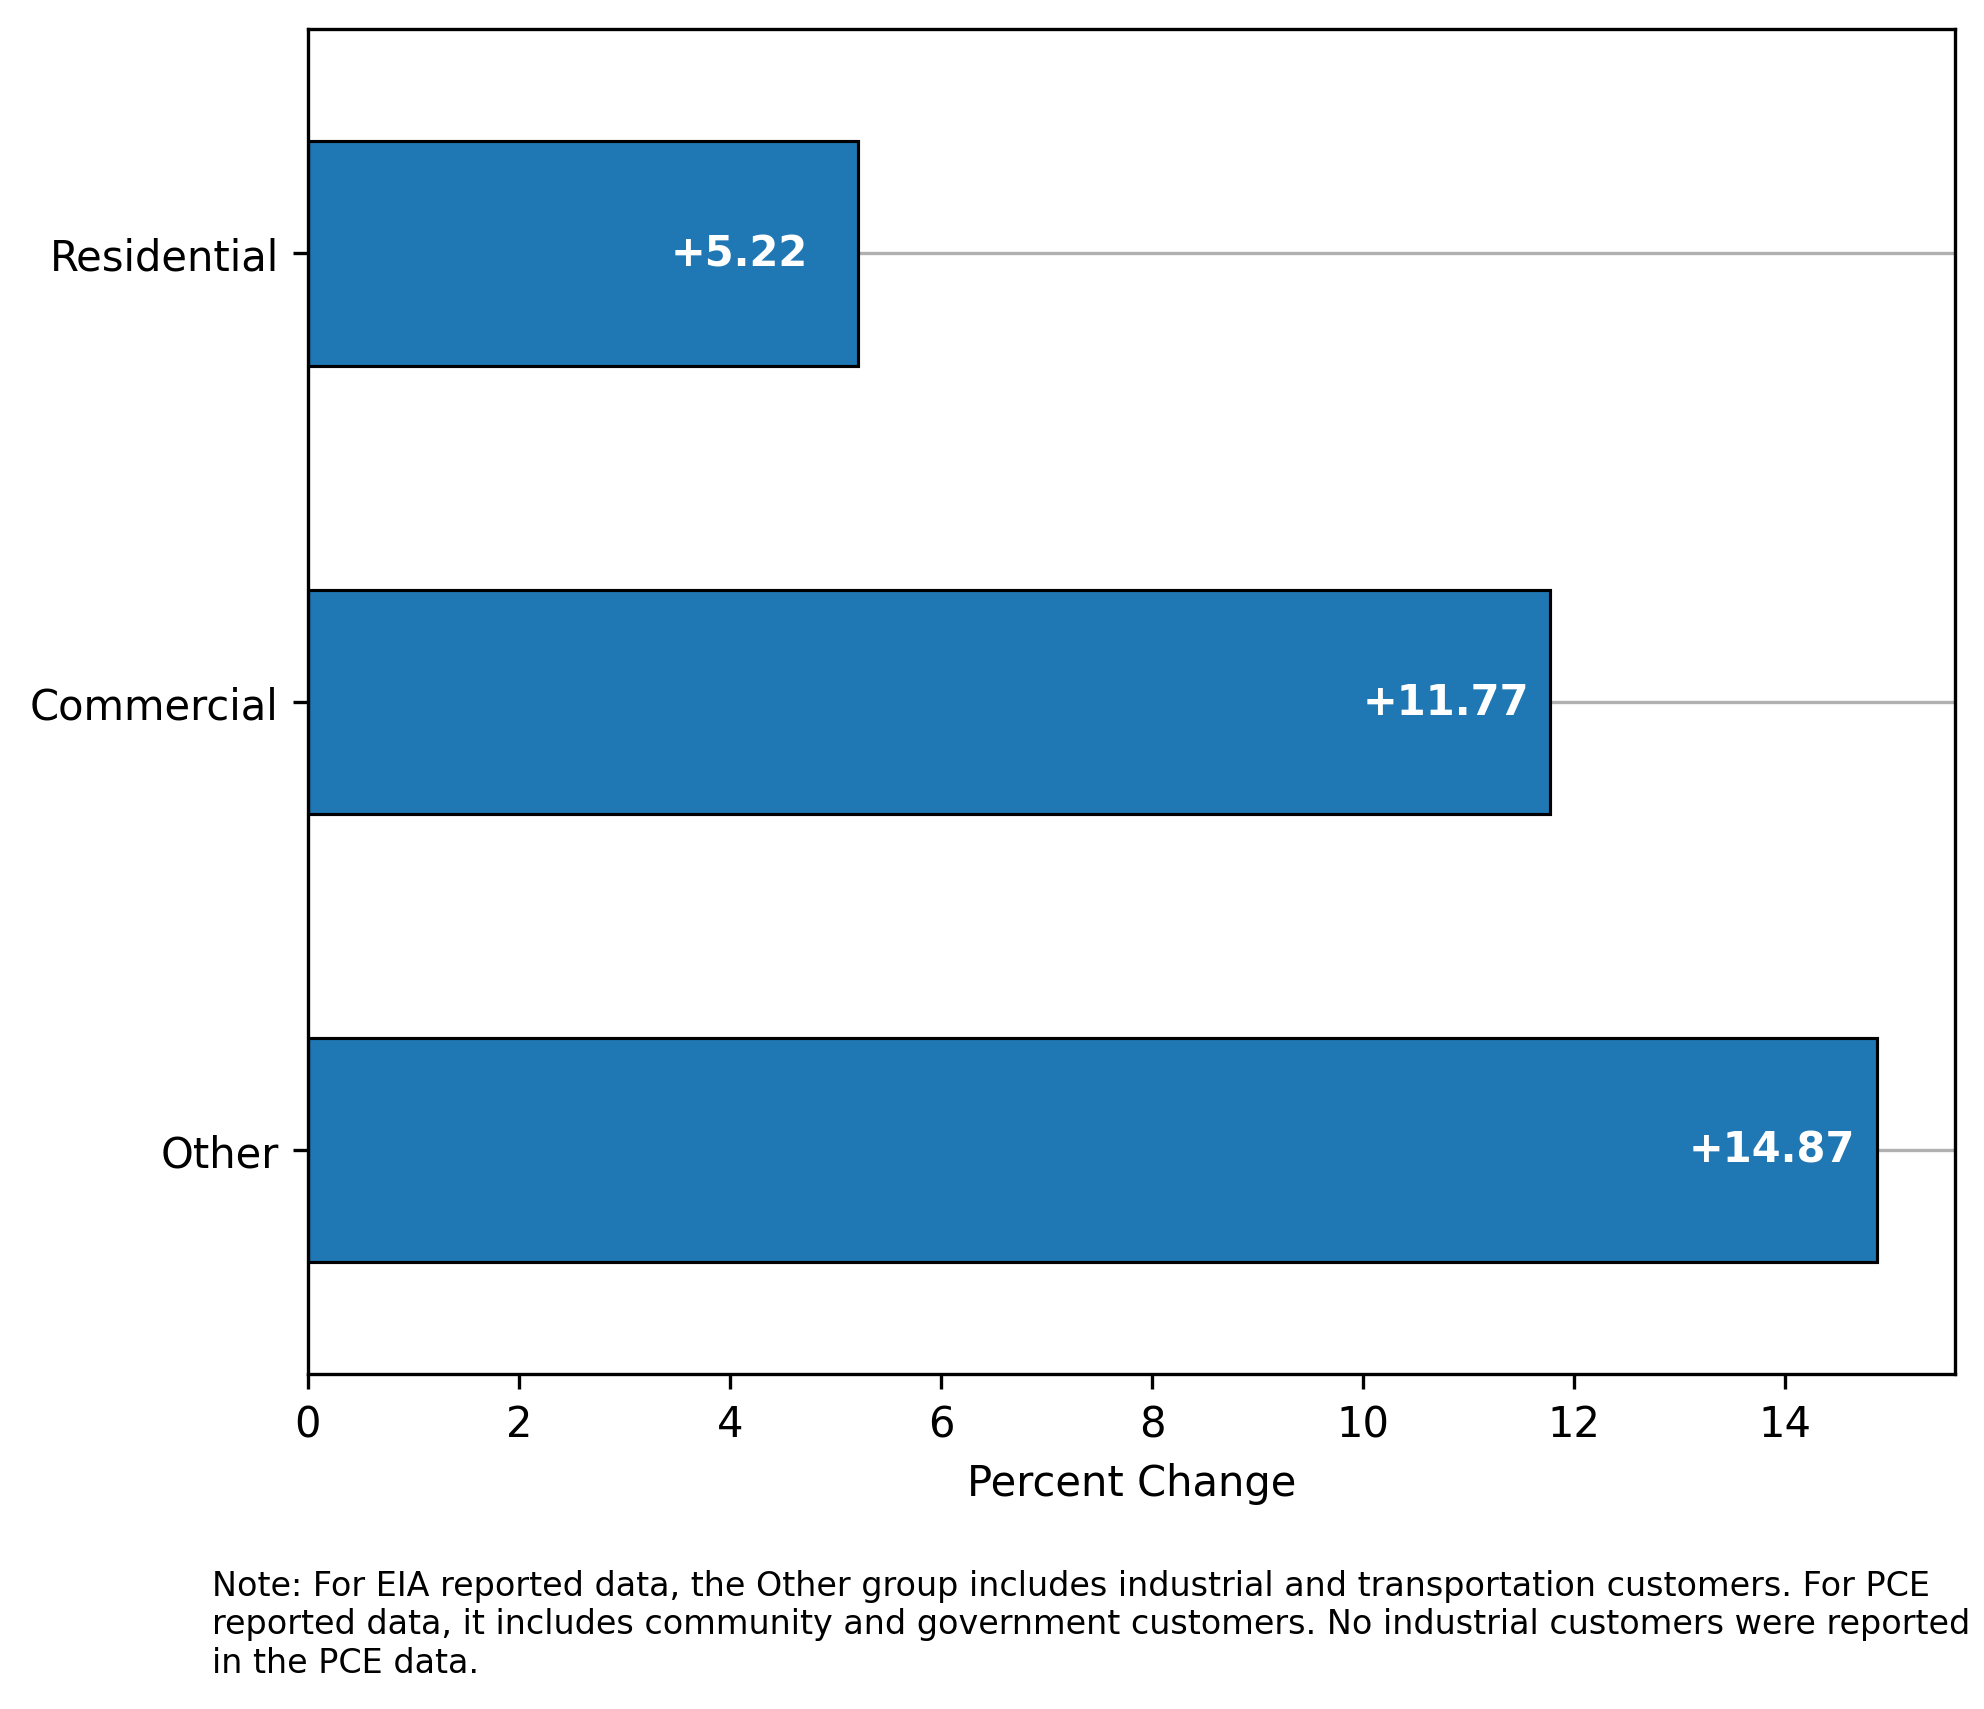

In [65]:
# Plotting and saving the percent change in total accounts (GWh) across state and customer classes
fig, ax = plt.subplots(figsize=(6.5,5), layout='constrained')
fig.set_dpi(300)
c.plot(kind='barh',y="Percent Change", edgecolor='black',linewidth=0.75, rot=0, ax=ax, legend=None)
ax.set_ylabel('')
ax.set_xlabel('Percent Change')
ax.grid(axis ='y')
ax.set_axisbelow(True)
for container in ax.containers:
    ax.bar_label(container,fmt='+{:.2f}', fontweight='bold',color='white', label_type='edge', padding=-45)
plt.figtext(0.1,-0.1,caption,wrap=True,ha='left',fontsize=8)
filename = 'statewide-accounts-delta'
plt.savefig(os.path.join(os.curdir,'figures',filename + '.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(os.curdir,'figures',filename + '.png'), bbox_inches='tight')

In [66]:
print(round(c,2))

Year              2011      2019  Percent Change
Other          4518.25    5190.0           14.87
Commercial    46410.62   51875.0           11.77
Residential  275473.18  289843.0            5.22


# Consumption per captia

In [67]:
# general trend
pc = pd.pivot_table(a[a.Year.isin(range(2011,2020))], 
        index=['ACEP Energy Region','Year'], 
        values=['Residential Sales','Residential Customers'], 
        aggfunc='sum')
pc['Per Capita Use (kWh)'] = (pc['Residential Sales'] / pc['Residential Customers']) * 1000000 # GWh to MWh
pc = pc[['Per Capita Use (kWh)']].reset_index()
pc = pc.pivot(columns='ACEP Energy Region', index='Year', values='Per Capita Use (kWh)')


In [68]:
# exporting the consumption per capita table to an appendix table
pc.astype(int).to_csv(os.path.join(os.curdir,'tables','consumption-per-capita.csv'))

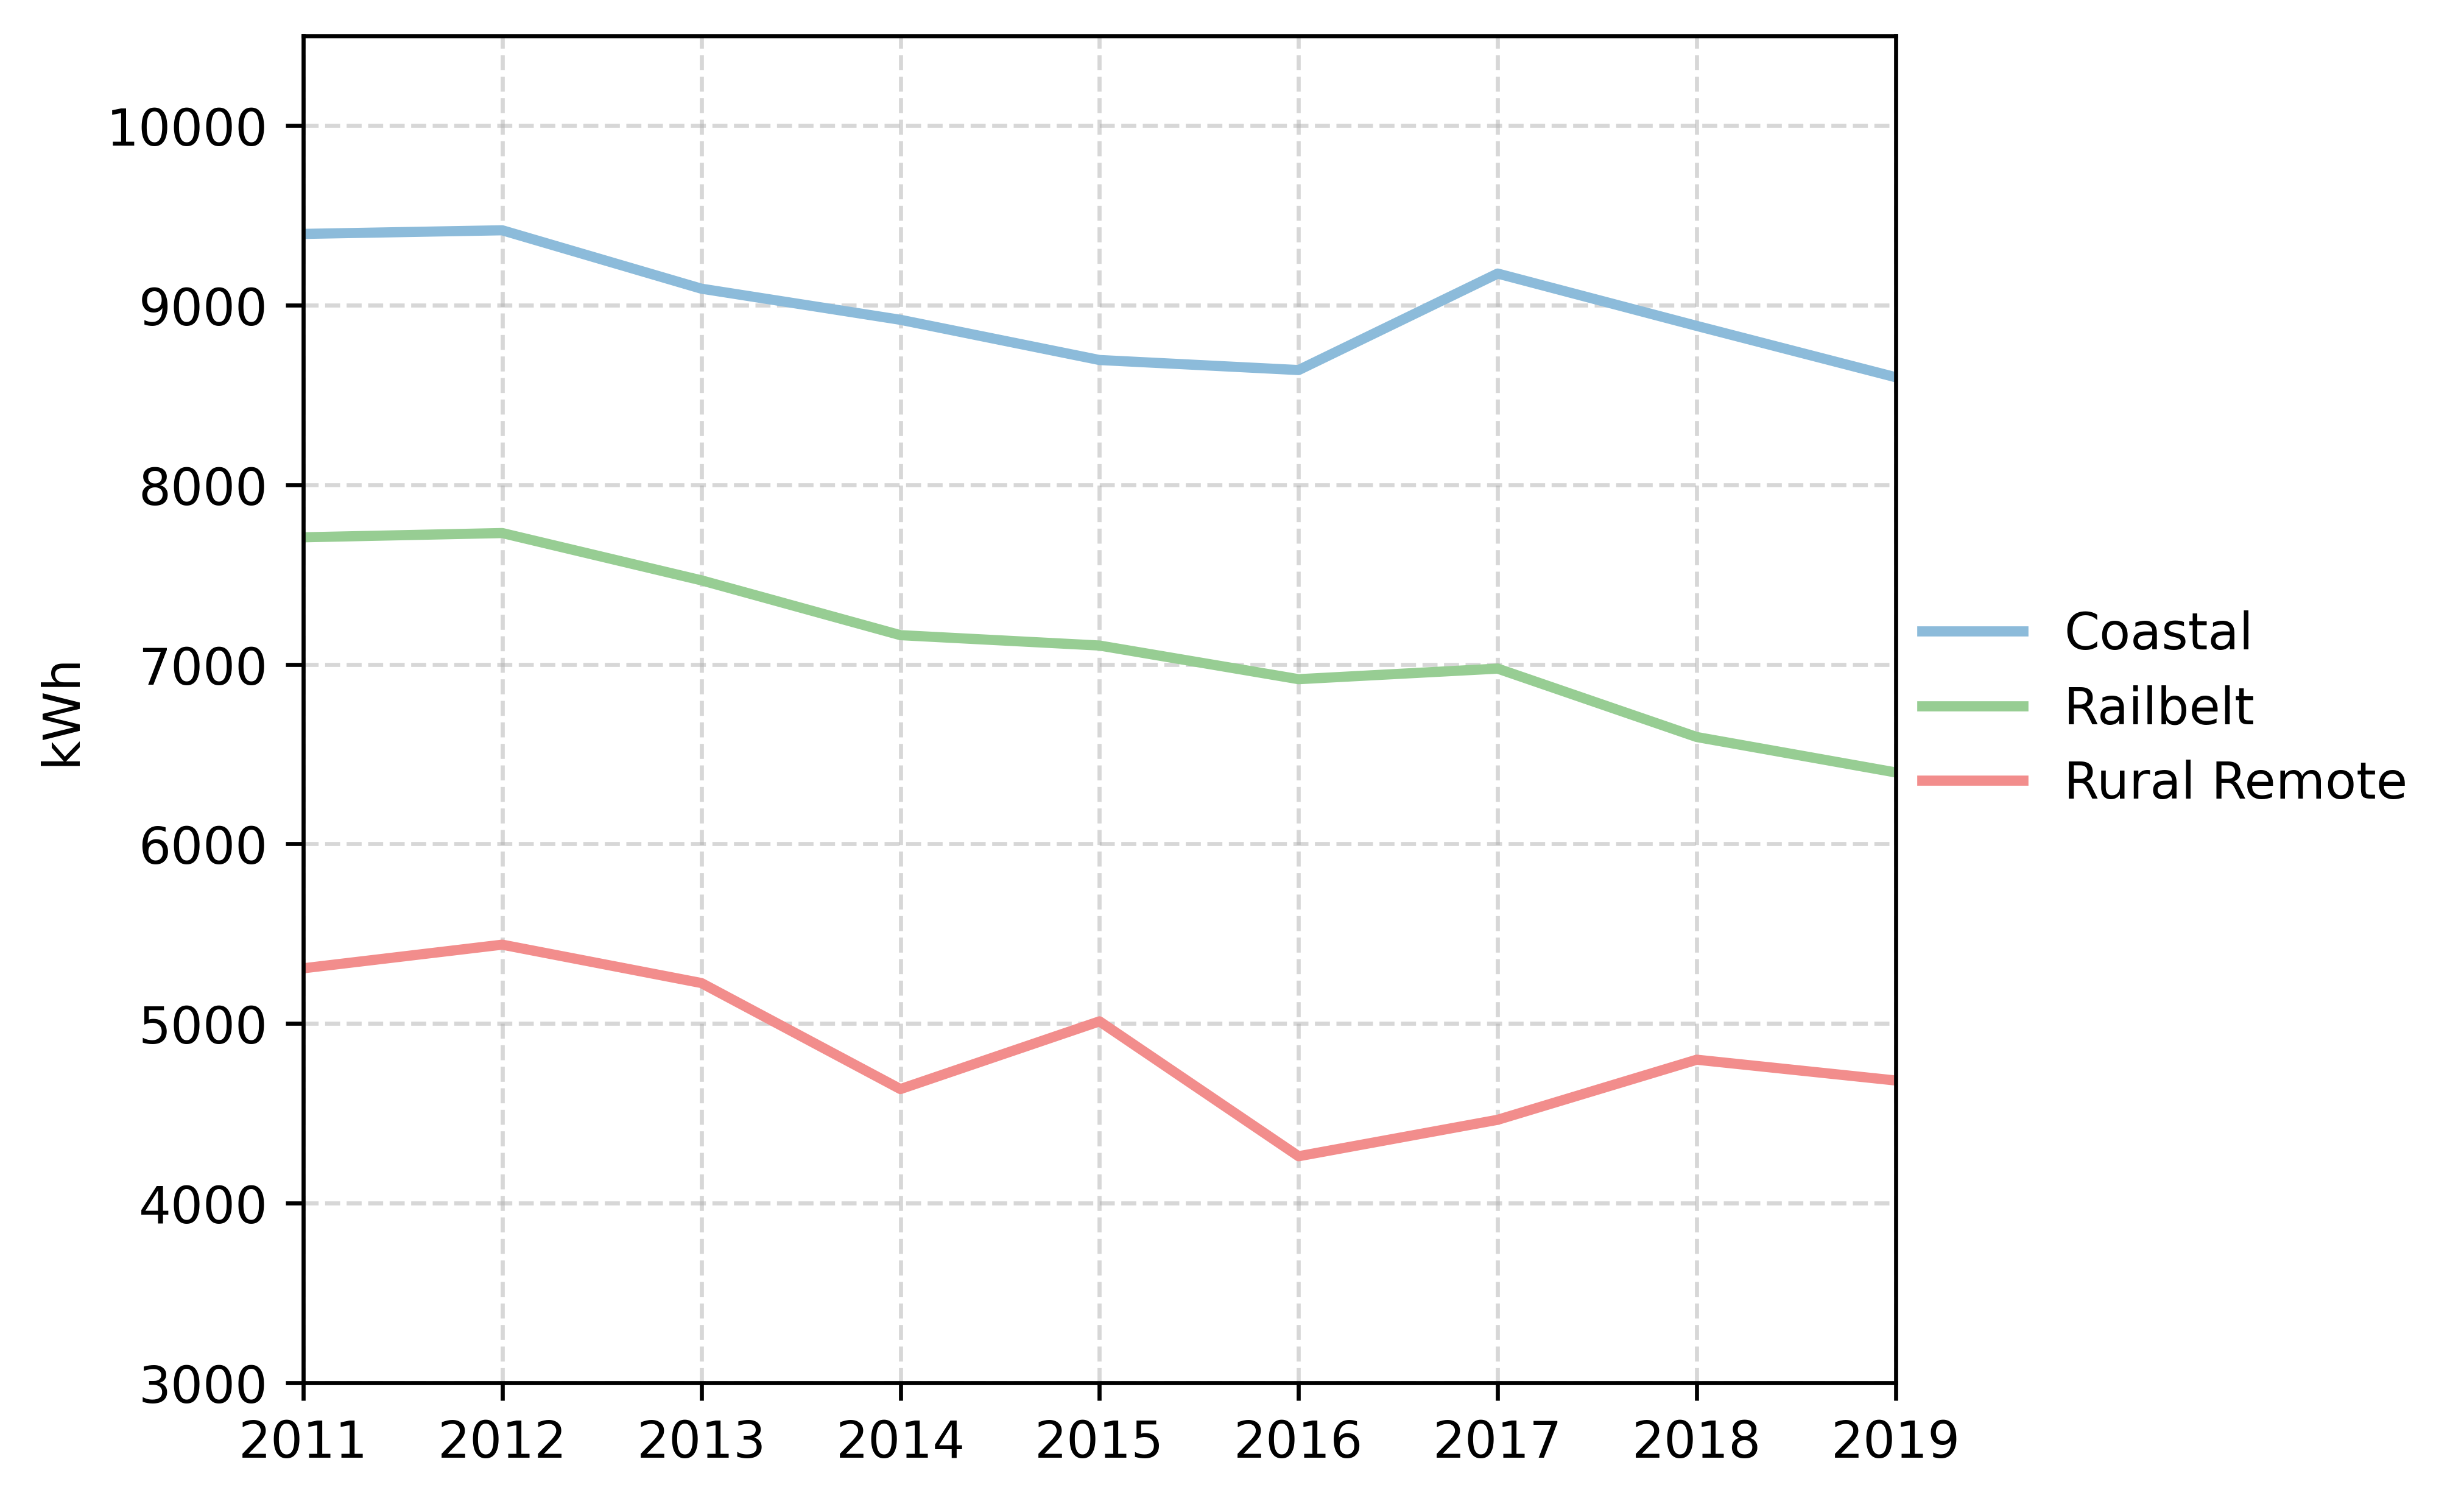

In [69]:
# setting up the figure
fig, ax = plt.subplots(figsize=(6.5,4), layout='constrained')
fig.set_dpi(600)
pc.plot(rot=0, alpha=1, color=schemes['energy_regions'],lw=2, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('kWh')
ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5), ncol=1, frameon=False)
ax.grid(axis ='both', alpha=0.5,linestyle='--')
ax.set_ylim(3000,10500)
ax.set_axisbelow(True)
plt.margins(0,0)
plt.show()

In [70]:
# statistics for the report
print('Average Consumption Per Capita (2011 to 2019)')
for i in pc.columns:
    print(i + ' Average:', pc[i].mean().astype(int), 'kWh')

Average Consumption Per Capita (2011 to 2019)
Coastal Average: 8980 kWh
Railbelt Average: 7118 kWh
Rural Remote Average: 4869 kWh


## Regional Trends

## Sales

In [71]:
# Producing a pivot table with the energy region and year as the key
c = pd.pivot_table(a[a.Year.isin(range(2011,2020))],
                index = ['ACEP Energy Region', 'Year'],
                values = sales_list[:-1],
                aggfunc = 'sum').reset_index()
c = c[['ACEP Energy Region','Year','Residential Sales','Commercial Sales','Other Sales']] # reordering the columns

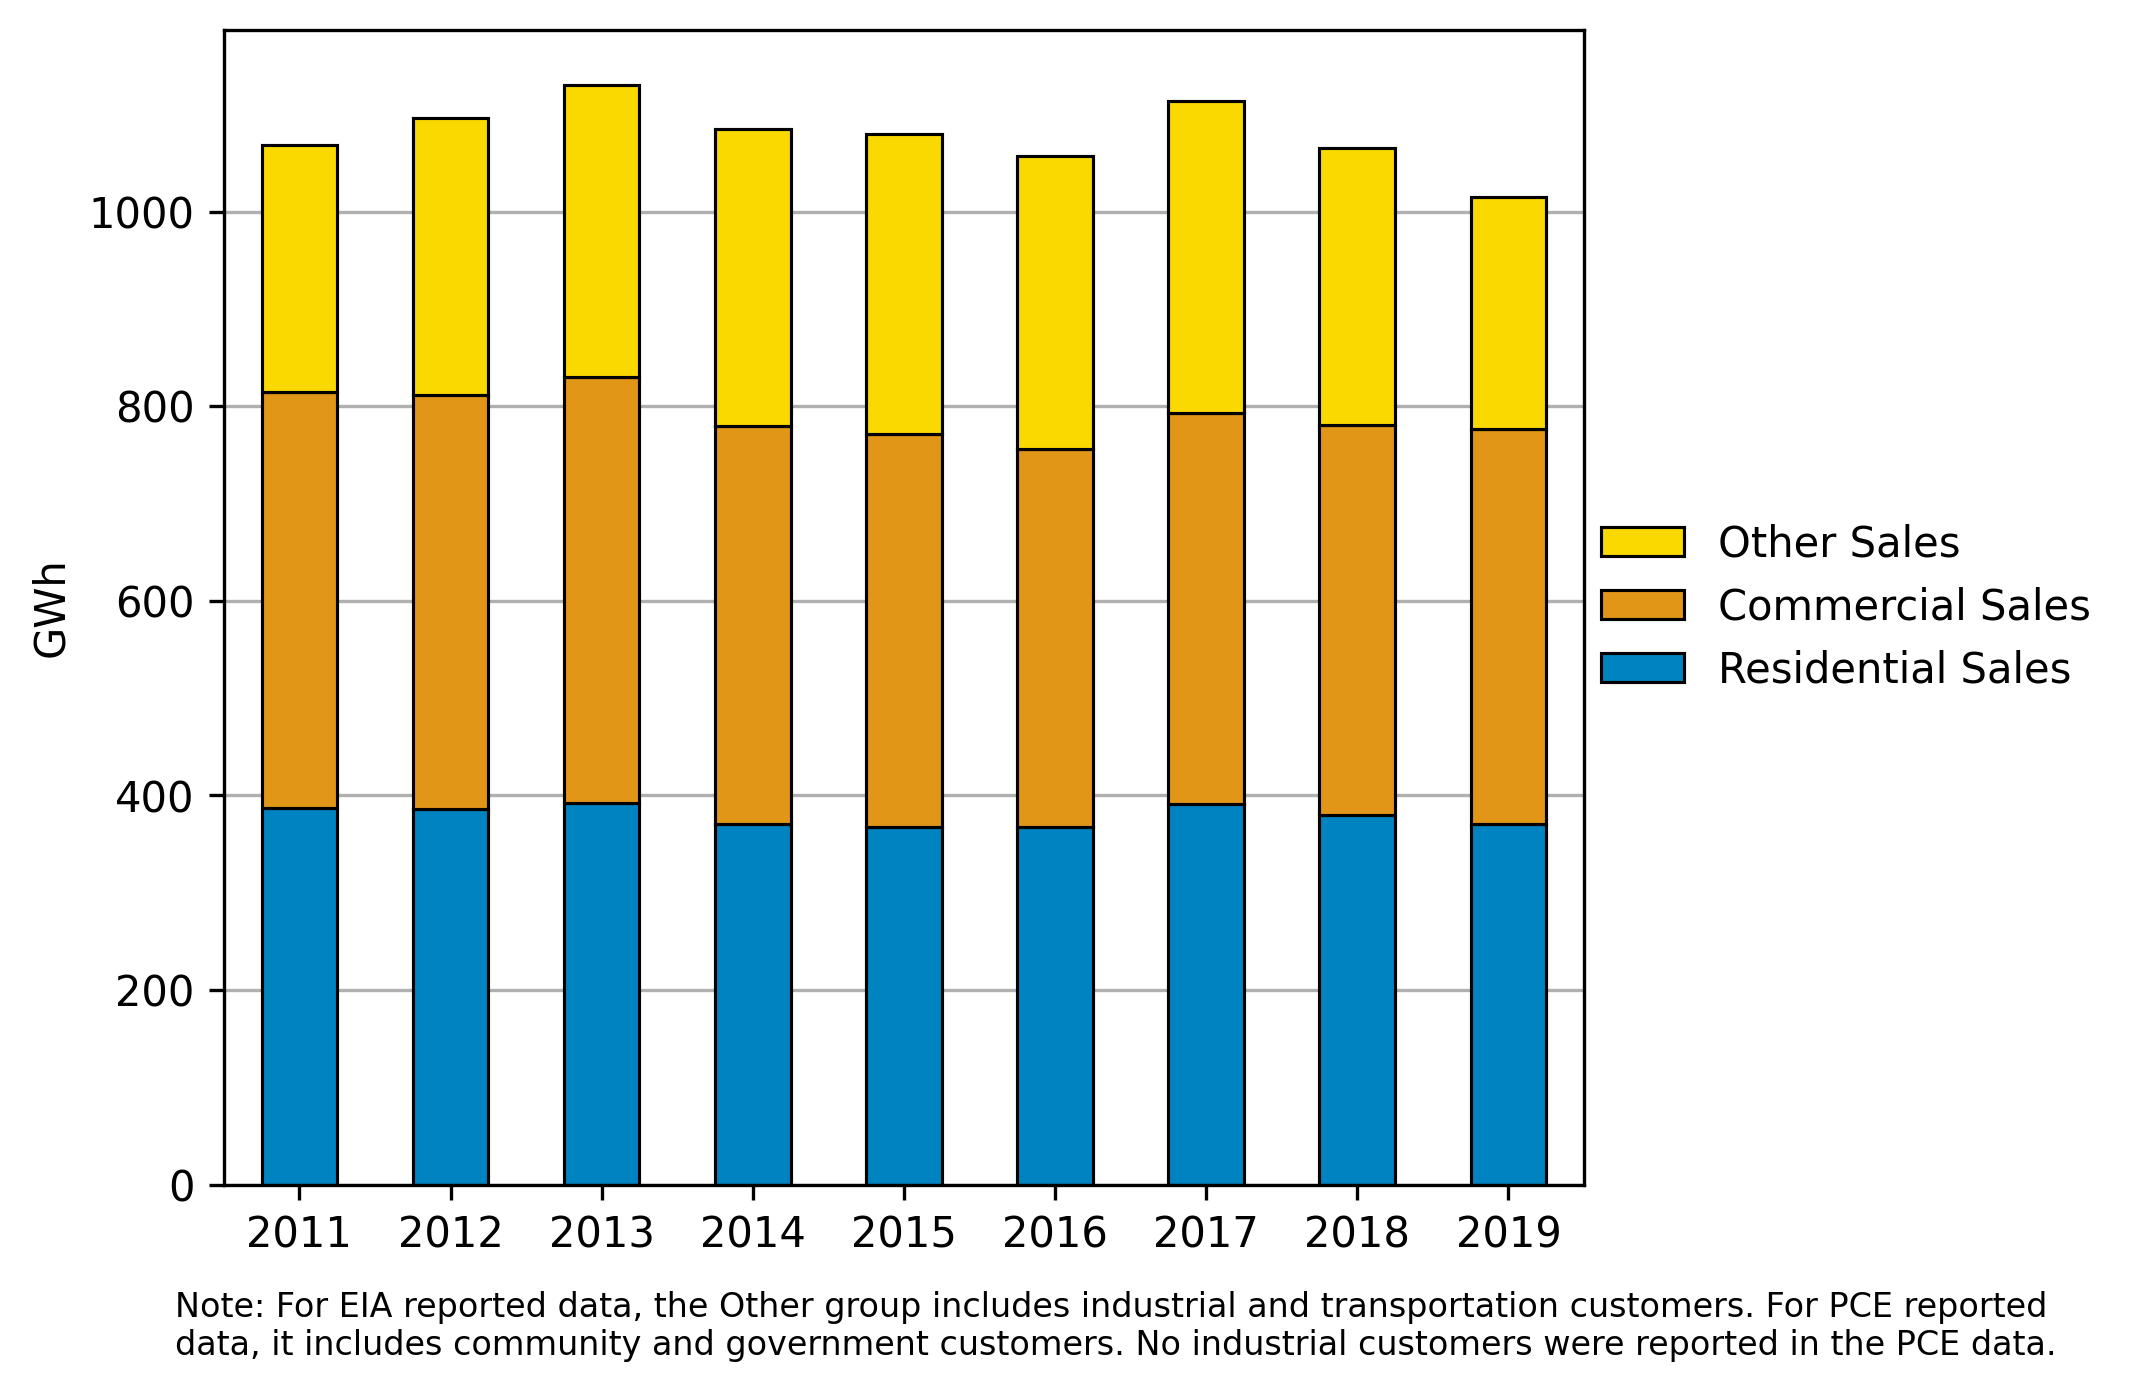

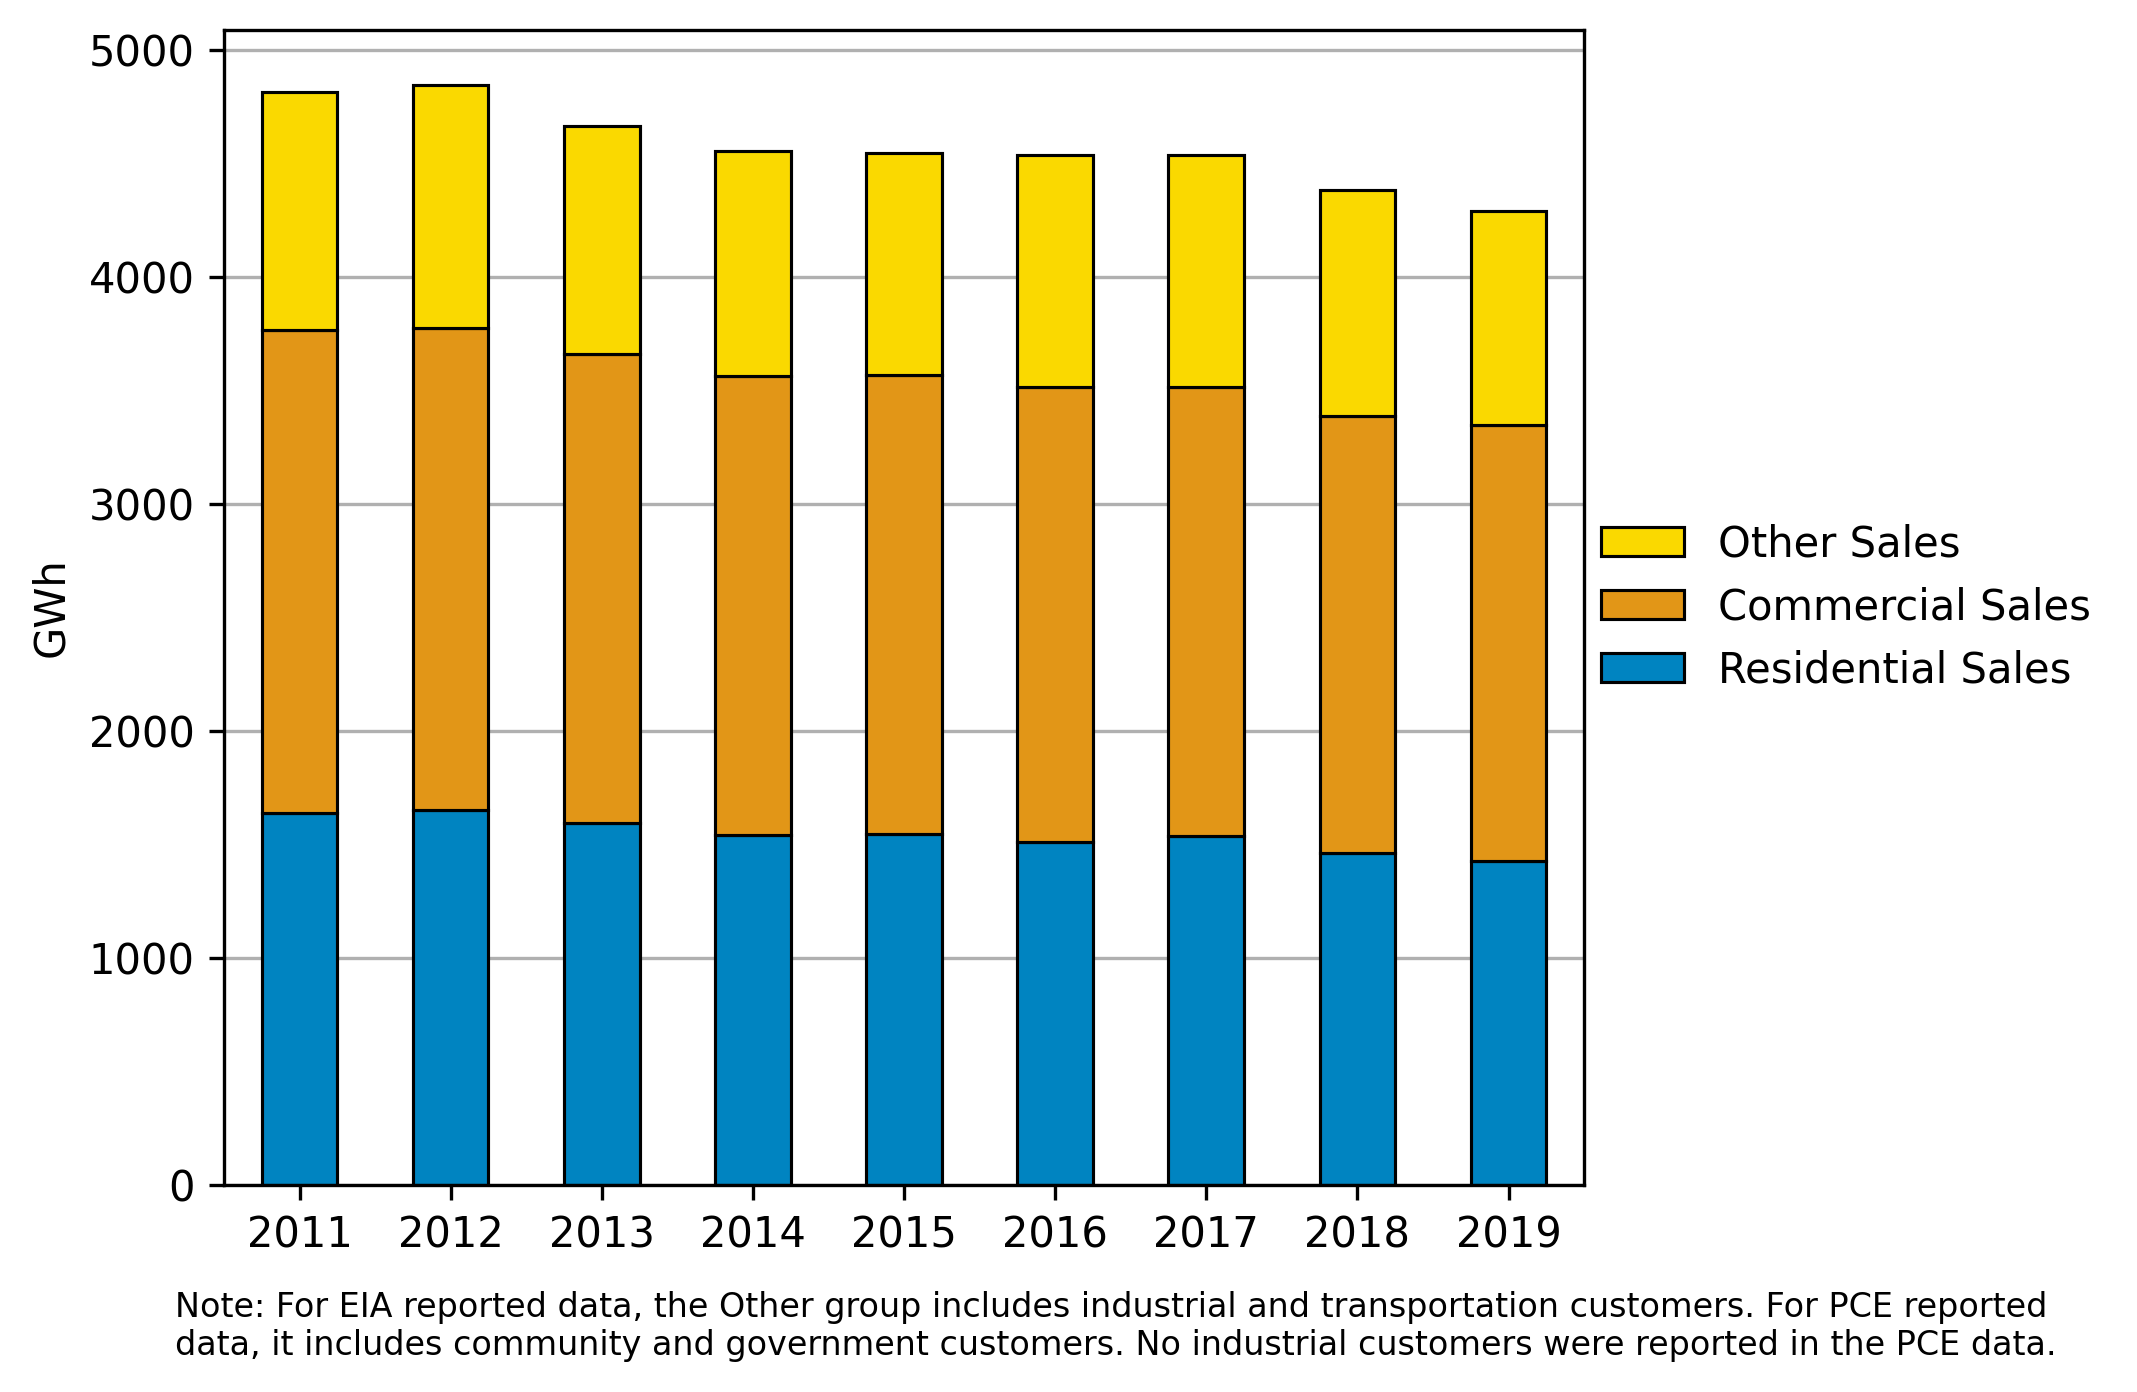

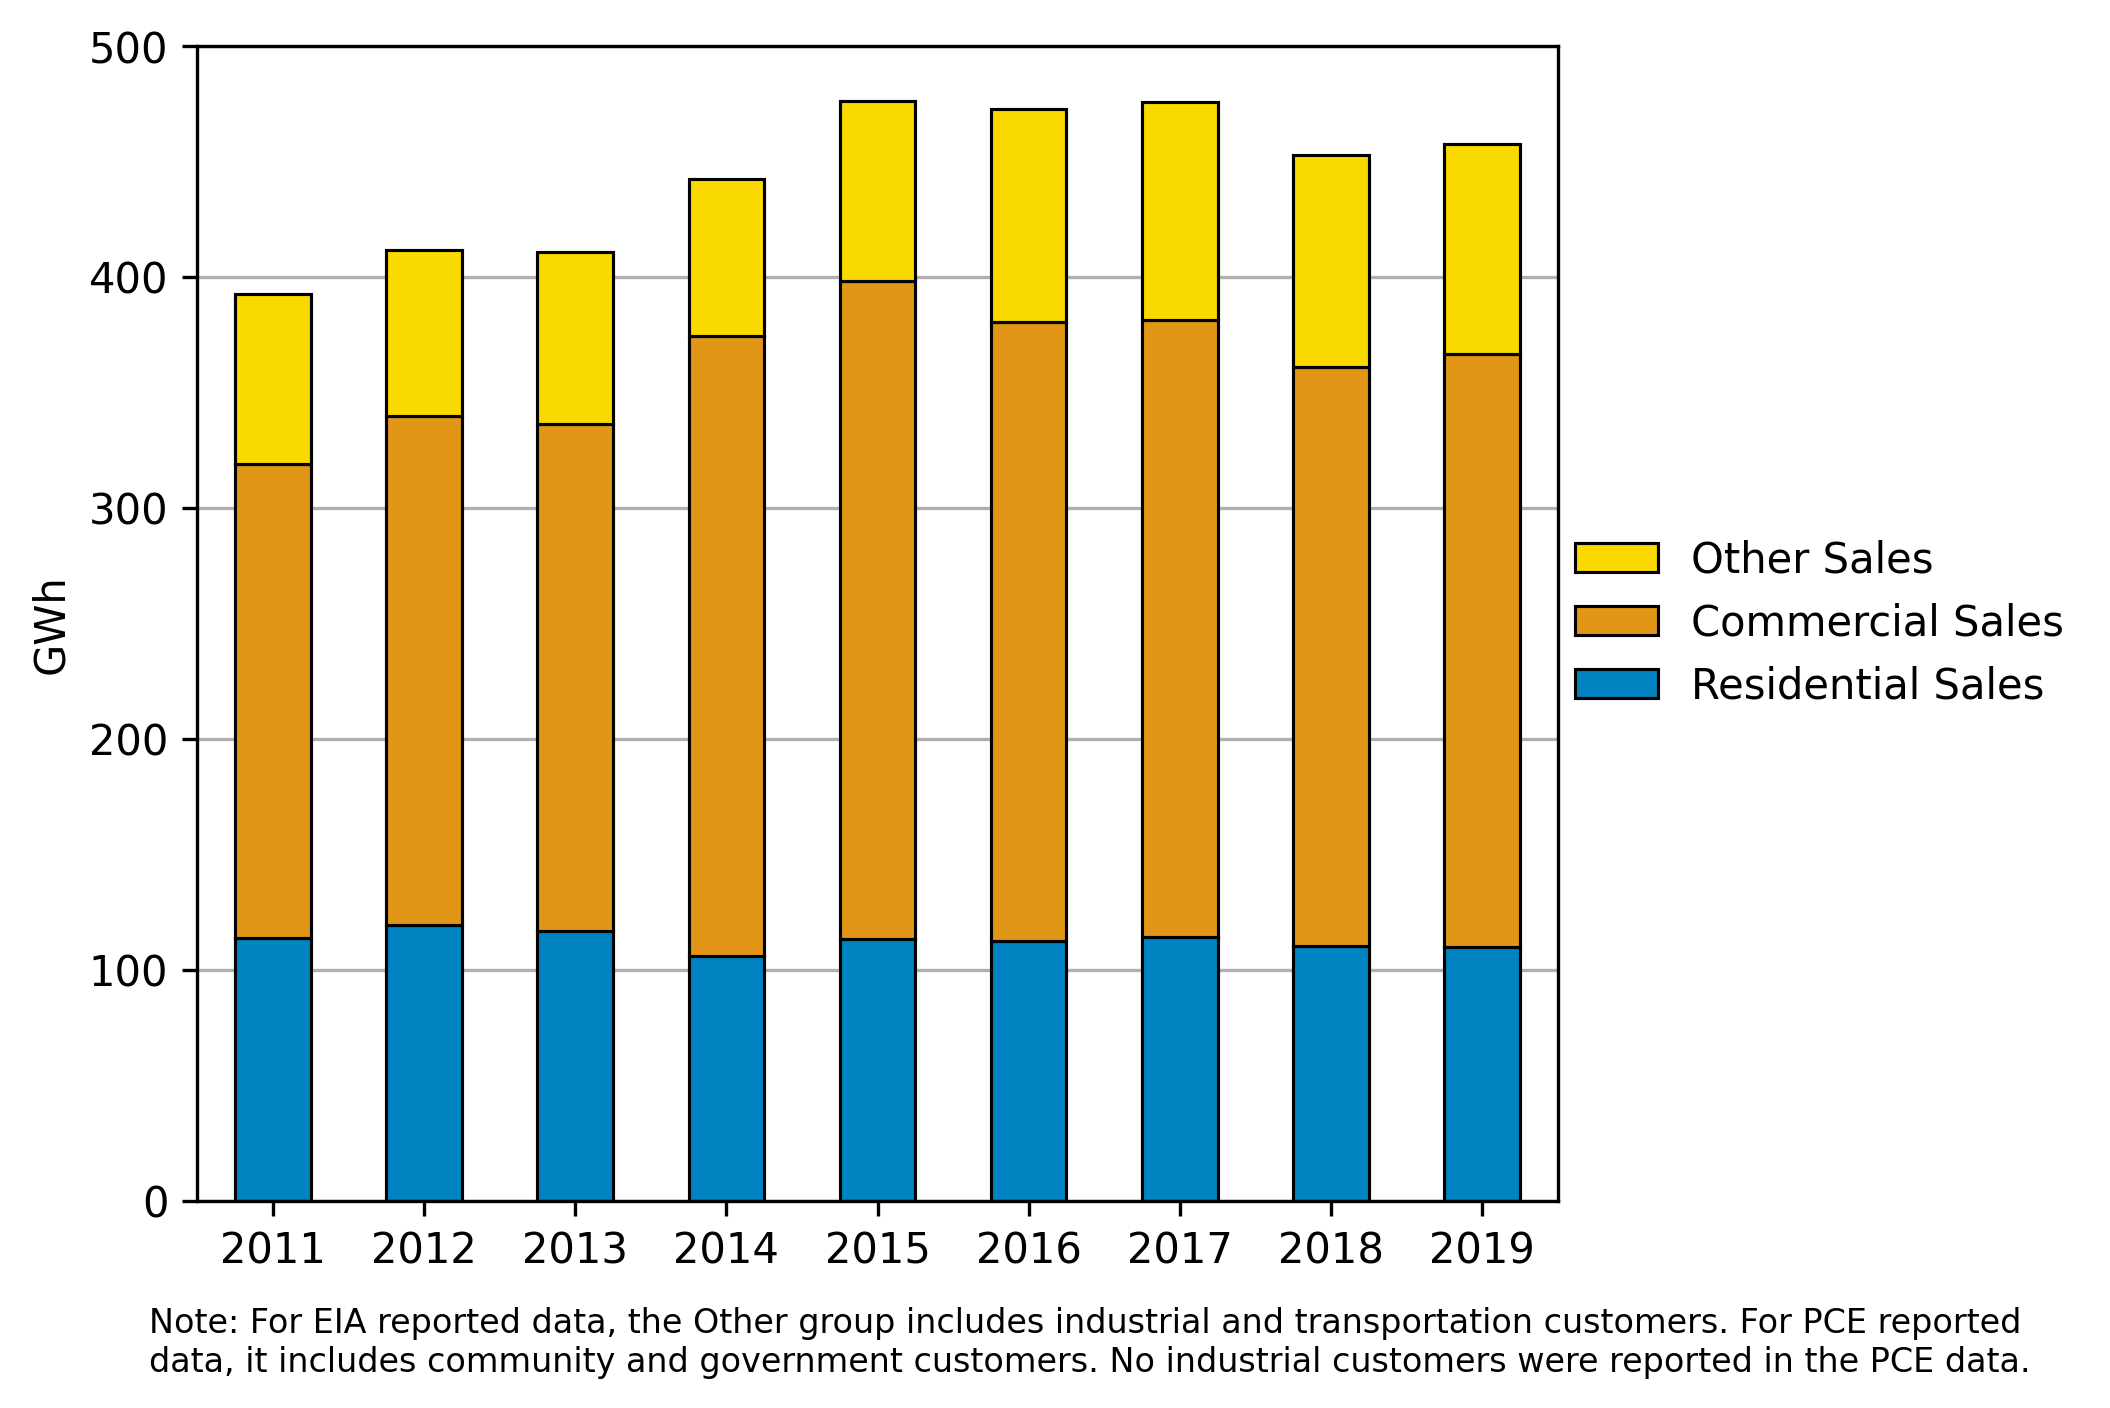

In [72]:
# Plotting sales by customer class for each region

for i in c['ACEP Energy Region'].unique().tolist():
    fig, ax = plt.subplots(figsize=(6.5,5), layout='constrained')
    fig.set_dpi(300)
    c[c['ACEP Energy Region'] == i].plot(kind='bar',x='Year',y=c.columns.to_list()[2:], stacked=True, edgecolor='black',linewidth=0.75, rot=0, color=schemes['customer_types'], ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('GWh')
    ax.grid(axis ='y')
    ax.set_axisbelow(True)
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels),loc='center right', bbox_to_anchor=(1.4, 0.5), ncol=1, frameon=False)
    plt.figtext(0.1,0,caption,wrap=True,ha='left',fontsize=8)
    filename = i.lower().replace(' ','-') + '-regional-sales'
    plt.savefig(os.path.join(os.curdir,'figures',filename + '.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(os.curdir,'figures',filename + '.png'), bbox_inches='tight')

### CAGR for sales

In [73]:
for j in c['ACEP Energy Region'].unique().tolist():
    tmp = c[c['ACEP Energy Region'] == j].reset_index(drop=True)
    print(j,os.linesep,'---')
    for i in tmp.columns.to_list()[2:]:
        print(i, round(((tmp[i][8] / tmp[i][0])**(1 / (8)) - 1)*100,2),'%')
    print(os.linesep)

Coastal 
 ---
Residential Sales -0.56 %
Commercial Sales -0.63 %
Other Sales -0.76 %


Railbelt 
 ---
Residential Sales -1.71 %
Commercial Sales -1.27 %
Other Sales -1.31 %


Rural Remote 
 ---
Residential Sales -0.46 %
Commercial Sales 2.86 %
Other Sales 2.68 %




## Customer Accounts

In [74]:
# Producing a pivot table with the energy region and year as the key
d = pd.pivot_table(a[a.Year.isin(range(2011,2020))],
                index = ['ACEP Energy Region', 'Year'],
                values = customer_list[:-1],
                aggfunc = 'sum').reset_index()
d = d[['ACEP Energy Region','Year','Residential Customers','Commercial Customers','Other Customers']] # reordering the columns

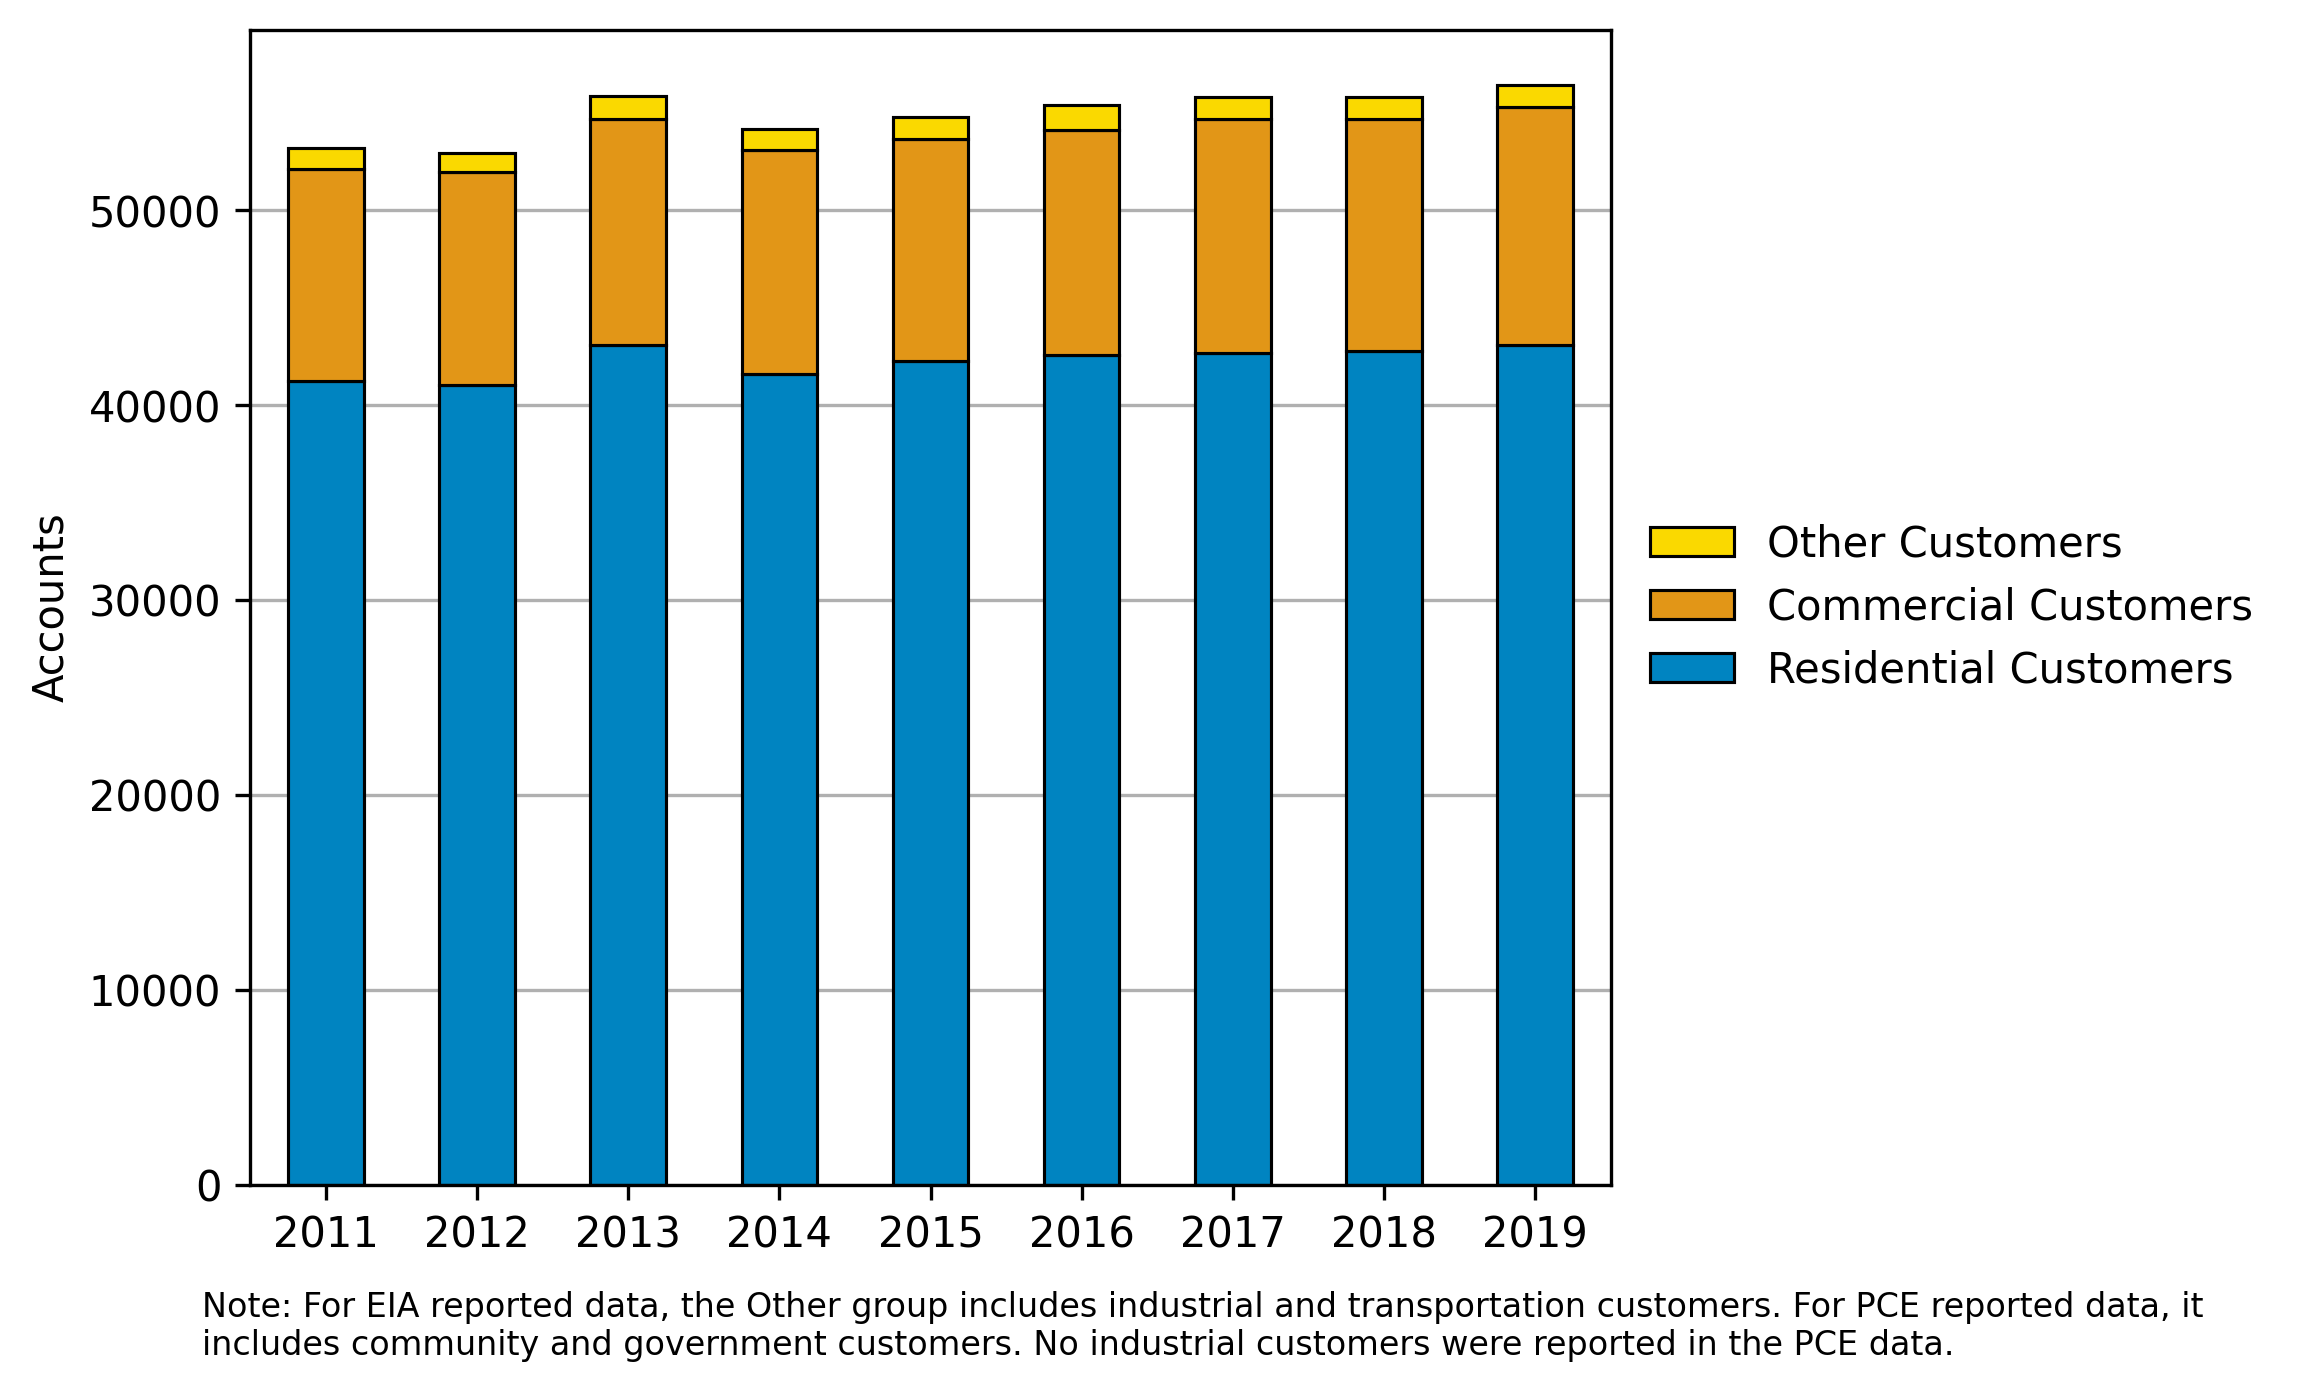

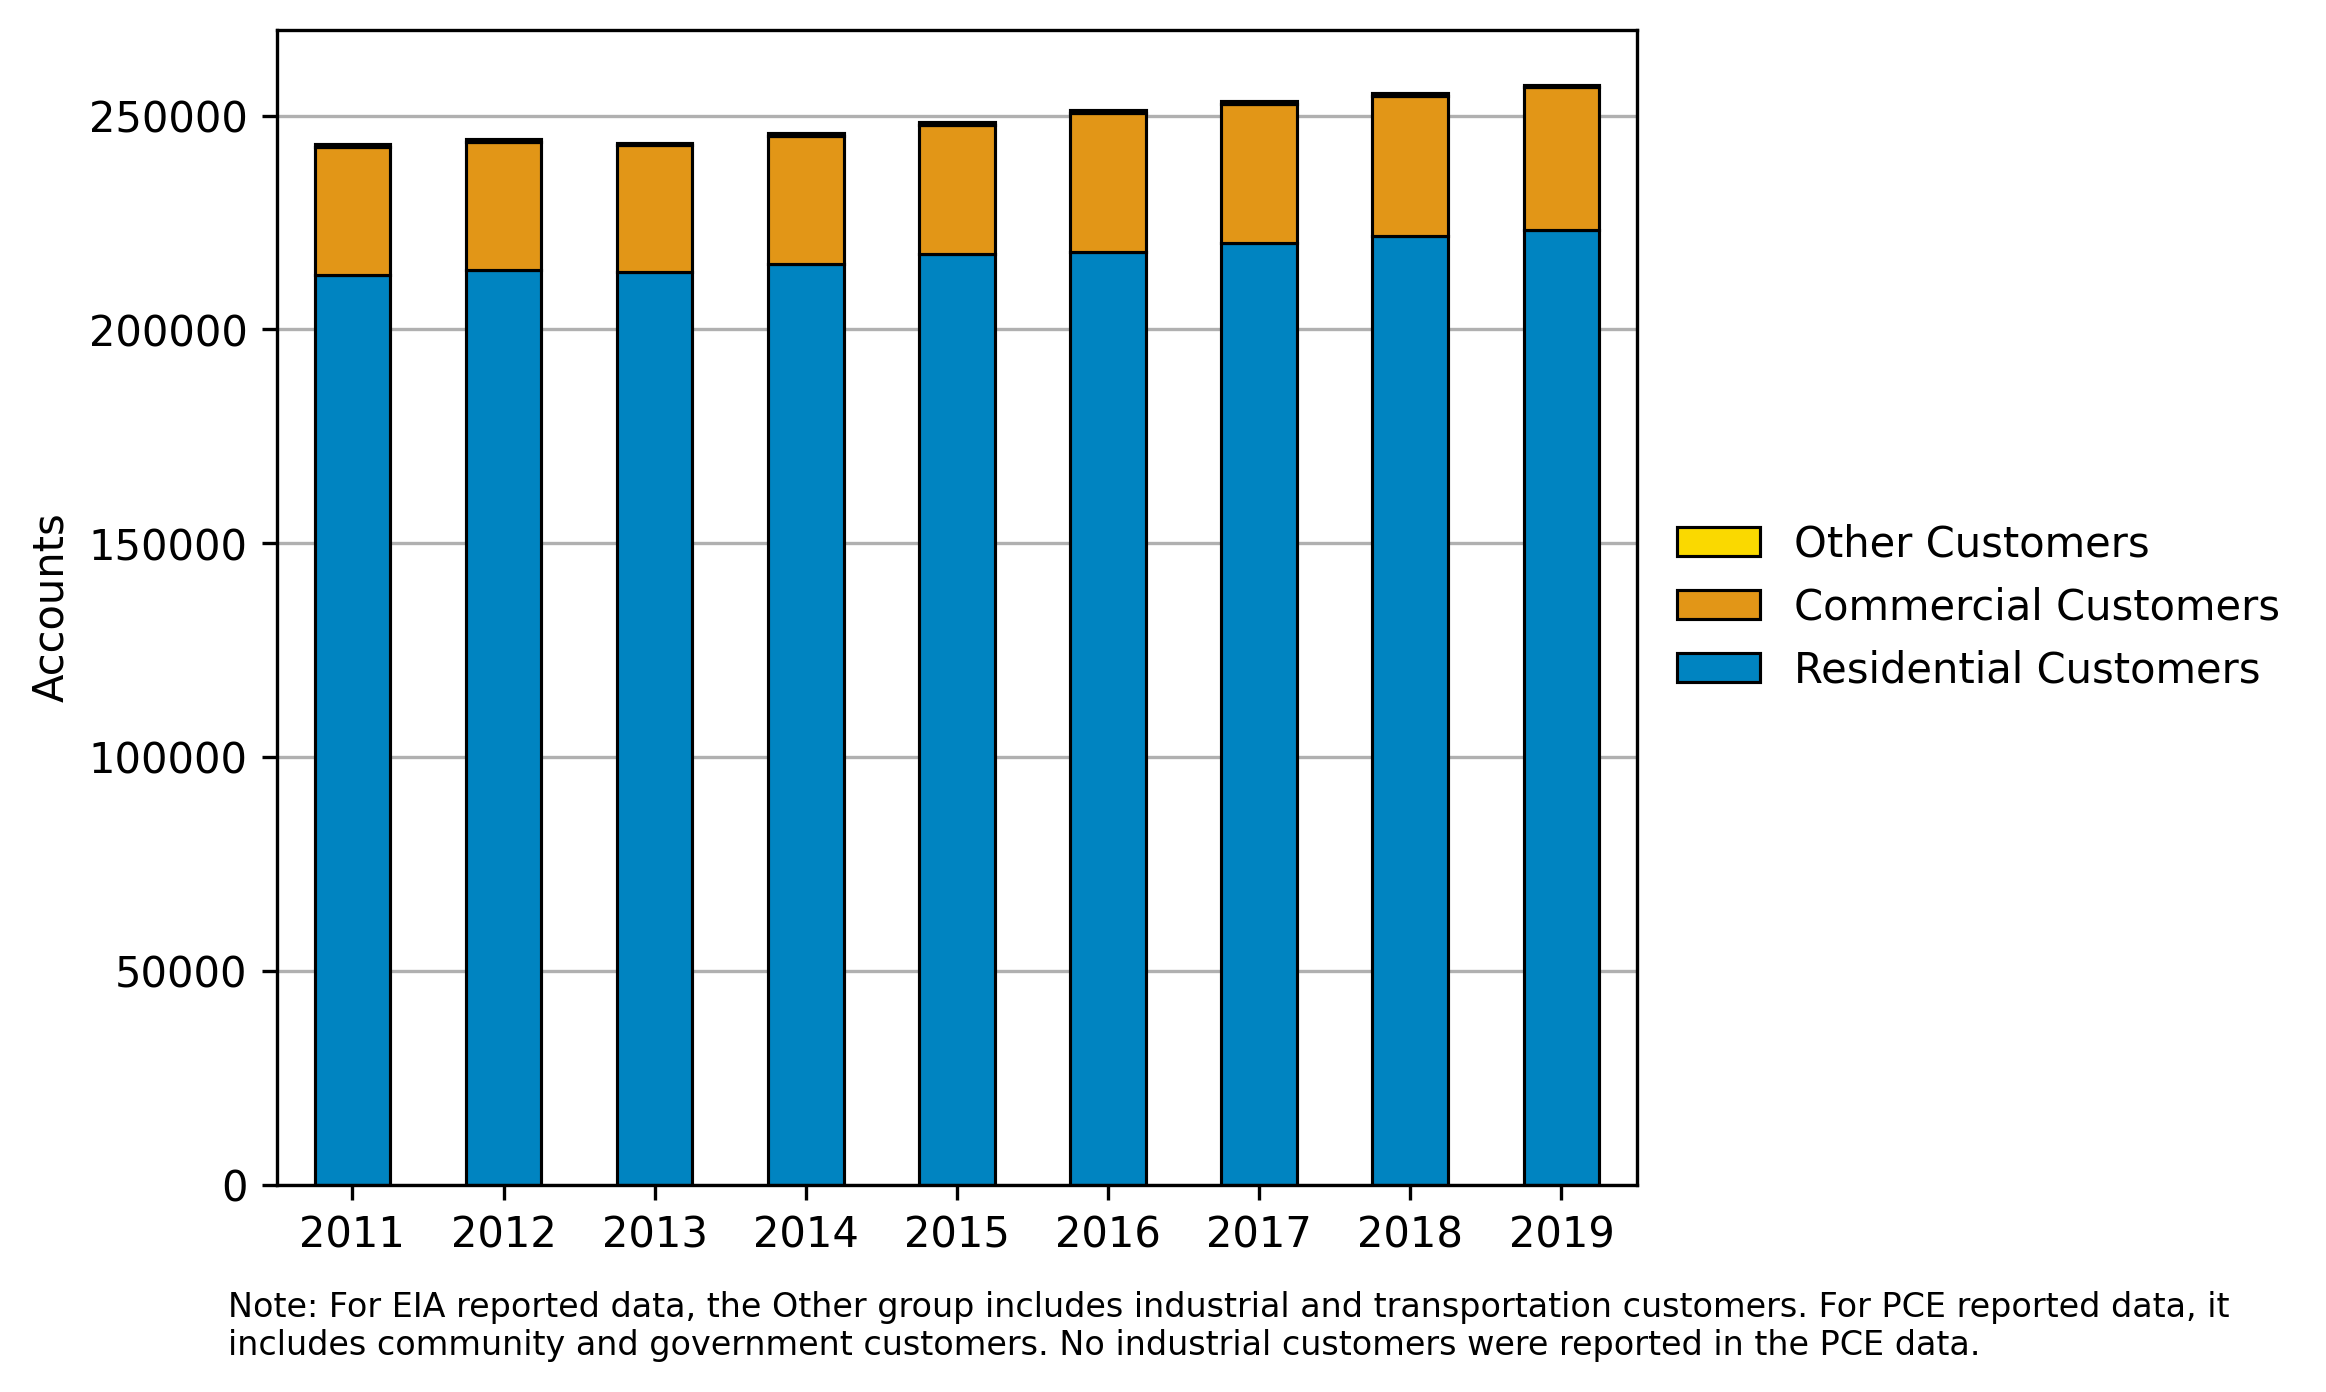

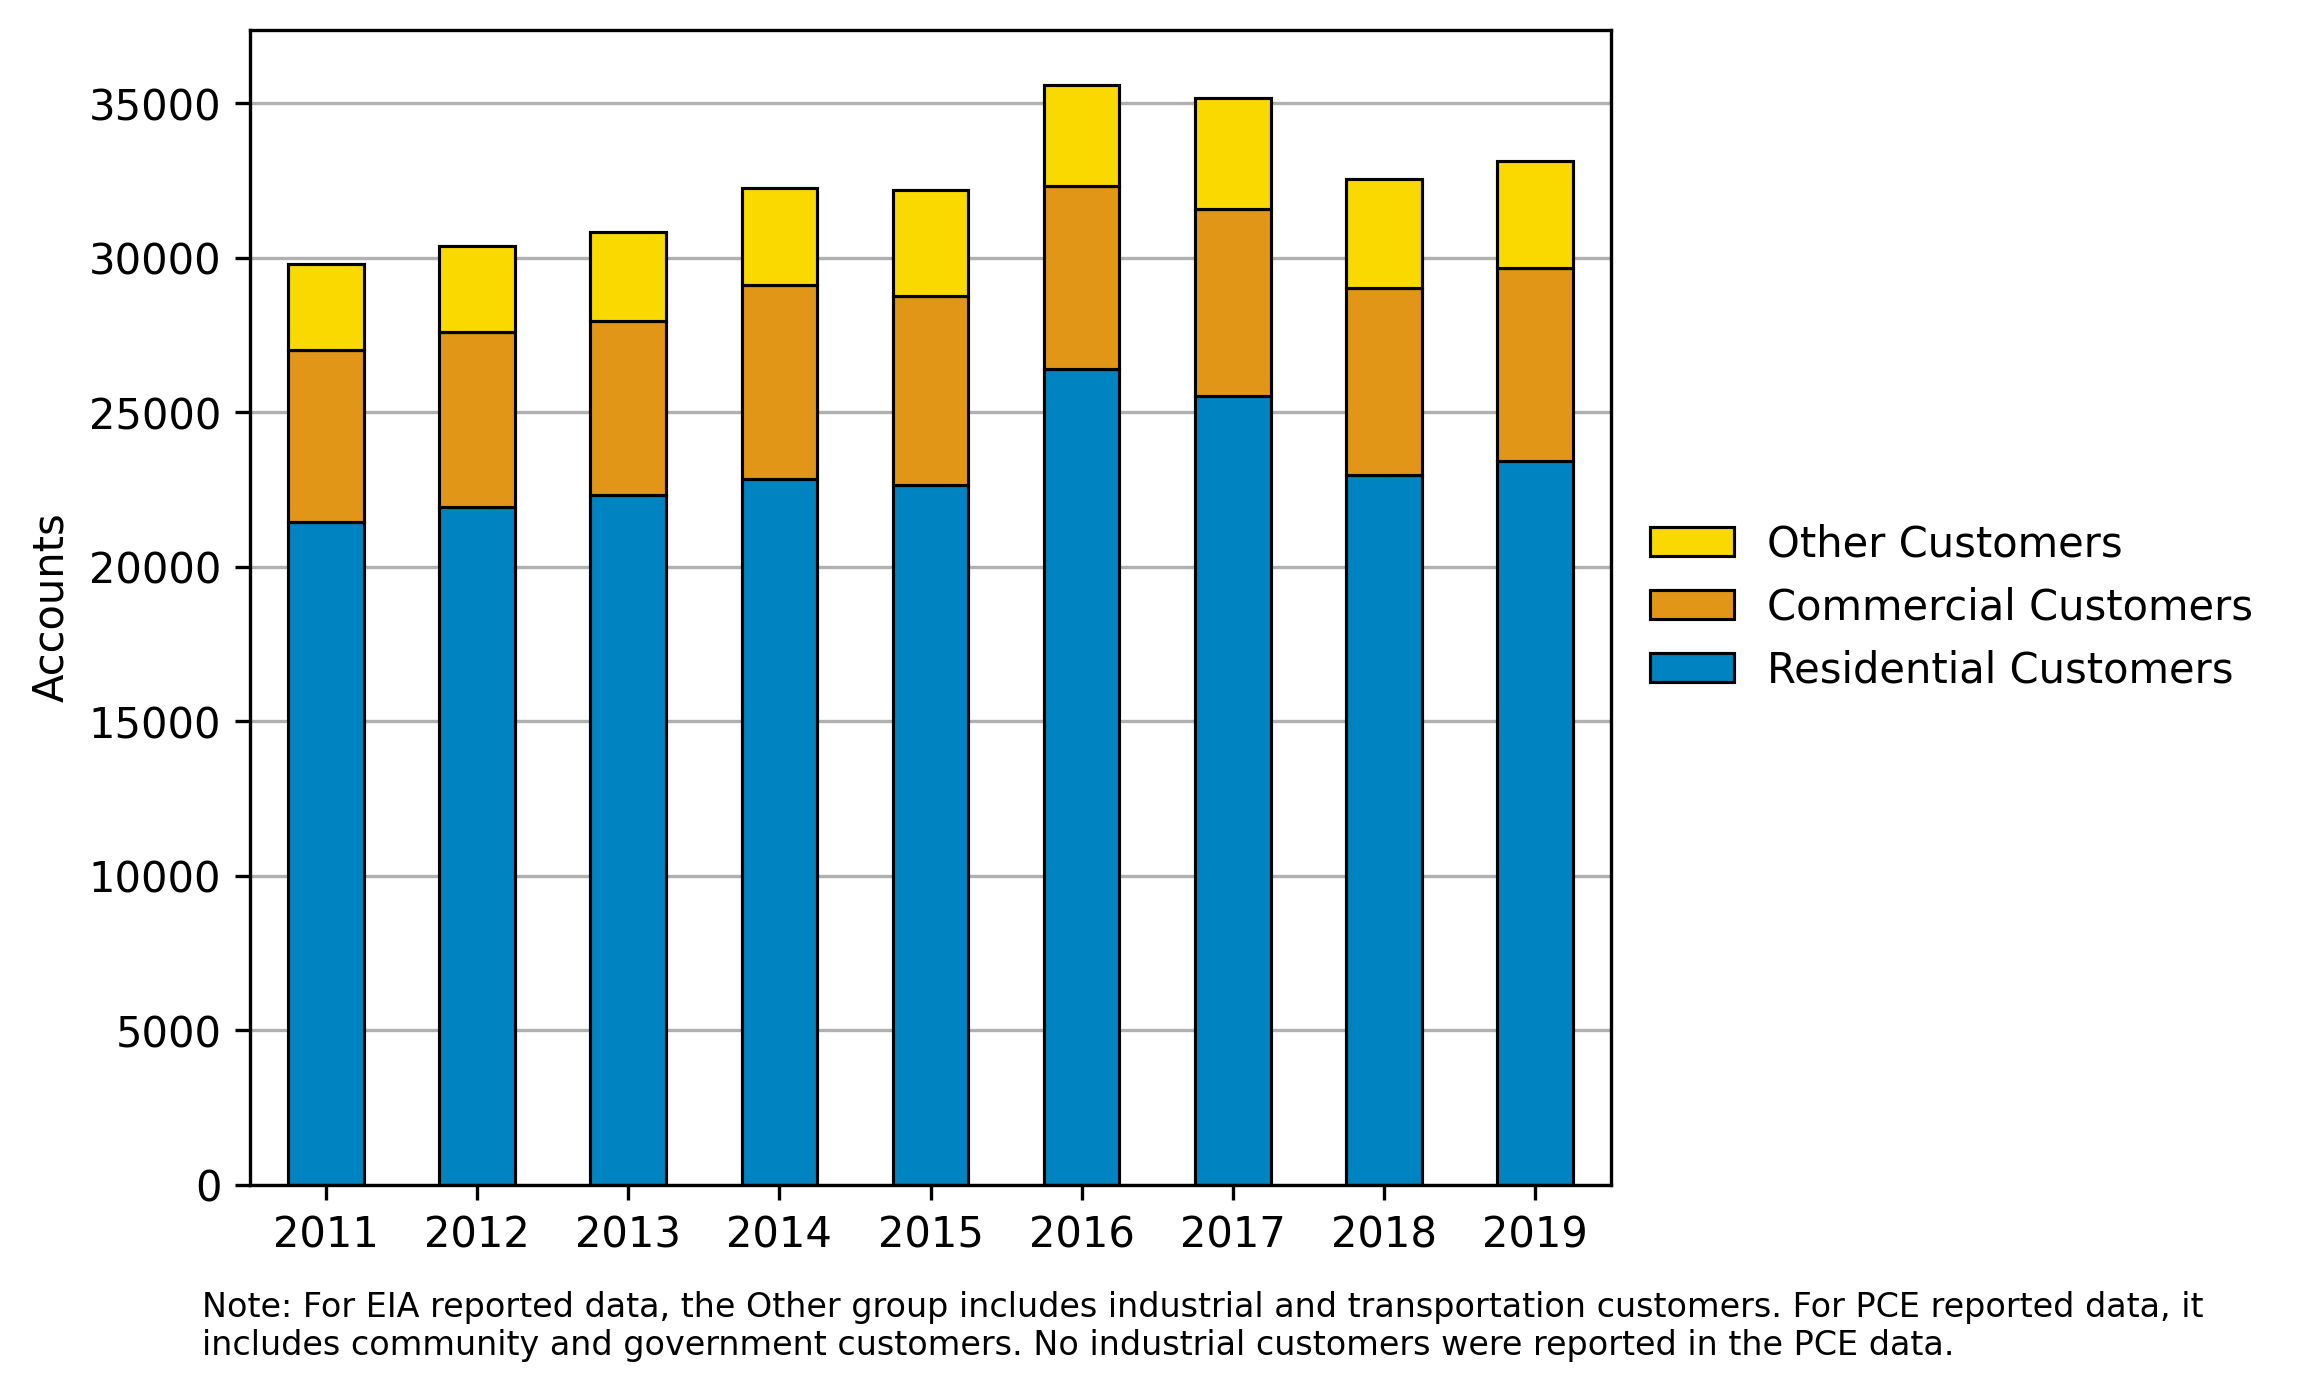

In [75]:
# Plotting sales by customer class for each region

for i in d['ACEP Energy Region'].unique().tolist():
    fig, ax = plt.subplots(figsize=(6.5,5), layout='constrained')
    fig.set_dpi(300)
    d[d['ACEP Energy Region'] == i].plot(kind='bar',x='Year',y=d.columns.to_list()[2:], stacked=True, edgecolor='black',linewidth=0.75, rot=0, color=schemes['account_types'], ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('Accounts')
    ax.grid(axis ='y')
    ax.set_axisbelow(True)
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels),loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1, frameon=False)
    plt.figtext(0.1,0,caption,wrap=True,ha='left',fontsize=8)
    filename = i.lower().replace(' ','-') + '-regional-accounts'
    plt.savefig(os.path.join(os.curdir,'figures',filename + '.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(os.curdir,'figures',filename + '.png'), bbox_inches='tight')

### CAGR for customer accounts

In [76]:
for j in d['ACEP Energy Region'].unique().tolist():
    tmp = d[d['ACEP Energy Region'] == j].reset_index(drop=True)
    print(j,os.linesep,'---')
    for i in tmp.columns.to_list()[2:]:
        print(i, round(((tmp[i][8] / tmp[i][0])**(1 / (8)) - 1)*100,2),'%')
    print(os.linesep)

Coastal 
 ---
Residential Customers 0.55 %
Commercial Customers 1.43 %
Other Customers 0.73 %


Railbelt 
 ---
Residential Customers 0.6 %
Commercial Customers 1.37 %
Other Customers -1.64 %


Rural Remote 
 ---
Residential Customers 1.11 %
Commercial Customers 1.46 %
Other Customers 2.74 %


